Contact author via [LinkedIn](http://piomazur.pl/linkedin) or [Github](http://piomazur.pl/github)

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import json

import datasets
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import transformers
import torch
import torchvision
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

shap.initjs()

In [3]:
pd.options.display.max_colwidth = 300

# Data & models setup

## Data

### Read & show dataset

In [4]:
taxi_df = pd.read_csv("data/taxi_out_2020.csv.zip", compression="zip")
taxi_df

TaxiOut             DepDateTimeUTC OriginIcao DestIcao AirlineIcao  \
0             40  2020-01-01 00:00:00+00:00       KLAX     KSEA         ASA   
1             15  2020-01-01 00:00:00+00:00       KSFO     KLAX         SWA   
2             17  2020-01-01 00:00:00+00:00       KLAX     KSEA         ASA   
3             15  2020-01-01 00:00:00+00:00       KSBA     KDEN         SKW   
4             13  2020-01-01 00:00:00+00:00       KSLC     KPIT         DAL   
...          ...                        ...        ...      ...         ...   
4297095       11  2020-12-31 23:59:00+00:00       KSLC     KBIL         SKW   
4297096       10  2020-12-31 23:59:00+00:00       KPIE     KGSP         AAY   
4297097       11  2020-12-31 23:59:00+00:00       KMSY     KDEN         FFT   
4297098       11  2020-12-31 23:59:00+00:00       KMCI     KDEN         SWA   
4297099       20  2020-12-31 23:59:00+00:00       KDFW     KBFL         ASH   

         DepHourLocal  DepWeekdayLocal  DepMonthLocal  DepDateLocalIsHoliday  \
0                  16                1             12                  False   
1                  16                1             12                  False   
2                  16                1             12                  False   
3                  16                1             12                  False   
4                  17                1             12                  False   
...               ...              ...            ...                    ...   
4297095            16                3             12                  False   
4297096            18                3             12                  False   
4297097            17                3             12                  False   
4297098            17                3             12                  False   
4297099            17                3             12                  False   

         DepDateLocalDaysToNextHoliday  DepDateLocalDaysToPrevHoliday  
0                                    1                              6  
1                                    1                              6  
2                                    1                              6  
3                                    1                              6  
4                                    1                              6  
...                                ...                            ...  
4297095                              1                              6  
4297096                              1                              6  
4297097                              1                              6  
4297098                              1                              6  
4297099                              1                              6  

[4297100 rows x 11 columns]

### Convert categorical features

In [5]:
categorical_features = [
    "OriginIcao",
    "DestIcao",
    "AirlineIcao",
    "DepHourLocal",
    "DepWeekdayLocal",
    "DepMonthLocal",
]
taxi_df[categorical_features] = taxi_df[categorical_features].apply(
    lambda x: x.astype("category")
)

### Prepare features & target

In [6]:
# Prepare X & y
X = taxi_df.drop(columns=["TaxiOut", "DepDateTimeUTC"])
y = taxi_df.TaxiOut

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

### Sample dataset

In [7]:
sample_size = 0.1
X_test = X_val.sample(frac=sample_size)
y_test = y_val[X_test.index].reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

## Model

### Taxi prediction model

In [8]:
model = lgb.Booster(model_file="taxi_model.txt")
model.params["objective"] = "regression"

## Image model

In [9]:
image_model = torchvision.models.mobilenet_v3_small(pretrained=True).eval()

## Text model

In [10]:
raw_text_model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "nateraw/bert-base-uncased-emotion"
)
text_tokenizer = transformers.AutoTokenizer.from_pretrained(
    "nateraw/bert-base-uncased-emotion", use_fast=True
)
try:
    raw_text_model = raw_text_model.cuda()
except AssertionError:
    print("Torch not compiled with CUDA enabled. Using CPU.")
    raw_text_model = raw_text_model.cpu()
text_model = transformers.pipeline(
    "text-classification",
    model=raw_text_model,
    tokenizer=text_tokenizer,
    return_all_scores=True,
)

Torch not compiled with CUDA enabled. Using CPU.


# Feature Importance

## Permutation importance

### Calculate original error

In [11]:
# Code here
y_pred = model.predict(X_test)
original_error = mean_absolute_error(y_test, y_pred)
original_error

4.807532870595833

### Calculate permutation importance for feature OriginIcao

In [12]:
# Code here

# Choose your feature
col_to_shuffle = "OriginIcao"

# Make a copy of your feature
original_col = X_test[col_to_shuffle].copy()

# Shuffle feature values
shuffled_col = X_test[col_to_shuffle].sample(frac=1).reset_index(drop=True)
X_test[col_to_shuffle] = shuffled_col

# Predict & calculate new error
y_pred = model.predict(X_test)
new_error = mean_absolute_error(y_test, y_pred)

# Restore feature to original form
X_test[col_to_shuffle] = original_col

# Print error change
print(col_to_shuffle, new_error - original_error)

OriginIcao 0.6771875009390174


### Implement method that calculates permutation importance for a feature specified through parameter

In [13]:
# Code here
def permutation_importance(col_to_shuffle: str) -> float:
    # Make a copy of your feature
    original_col = X_test[col_to_shuffle].copy()

    # Shuffle feature values
    shuffled_col = X_test[col_to_shuffle].sample(frac=1).reset_index(drop=True)
    X_test[col_to_shuffle] = shuffled_col

    # Predict & calculate new error
    y_pred = model.predict(X_test)
    new_error = mean_absolute_error(y_test, y_pred)

    # Restore feature to original form
    X_test[col_to_shuffle] = original_col

    # Print error change
    print(col_to_shuffle, new_error - original_error)

    return new_error - original_error

### Calculate importances for all features

In [14]:
# Code here
perm_importances = {}
for column in X_test.columns:
    perm_importances[column] = permutation_importance(column)

OriginIcao 0.6762778730802763
DestIcao 0.1262261232936206
AirlineIcao 0.5710556654840566
DepHourLocal 0.14946161189166407
DepWeekdayLocal 0.003312481459139427
DepMonthLocal -0.012888715154950603
DepDateLocalIsHoliday 0.0002455236862122234
DepDateLocalDaysToNextHoliday 0.008024858371027399
DepDateLocalDaysToPrevHoliday -0.004520418411555482


### Plot calculated permutation importances

<AxesSubplot:title={'center':'Permutation importance'}>

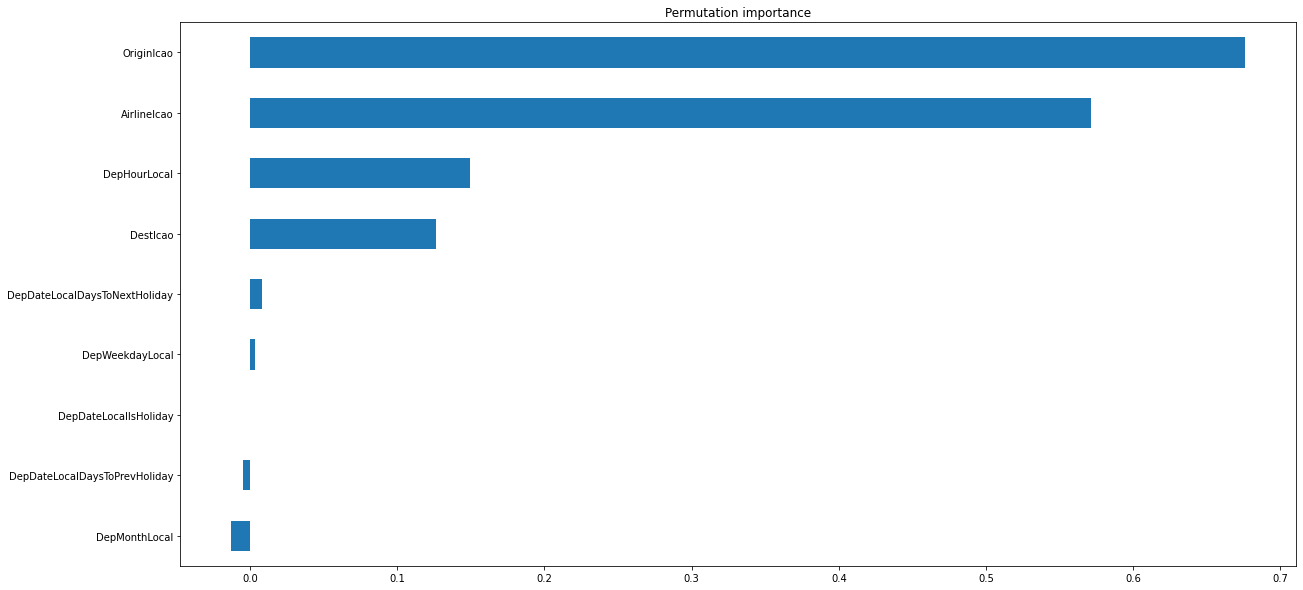

In [15]:
# Code here
pd.Series(perm_importances).sort_values().plot(
    title="Permutation importance", kind="barh", figsize=(20, 10)
)

## Built-in feature importance

### Plot feature importance using [lgb.plot_importance](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_importance.html) method

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

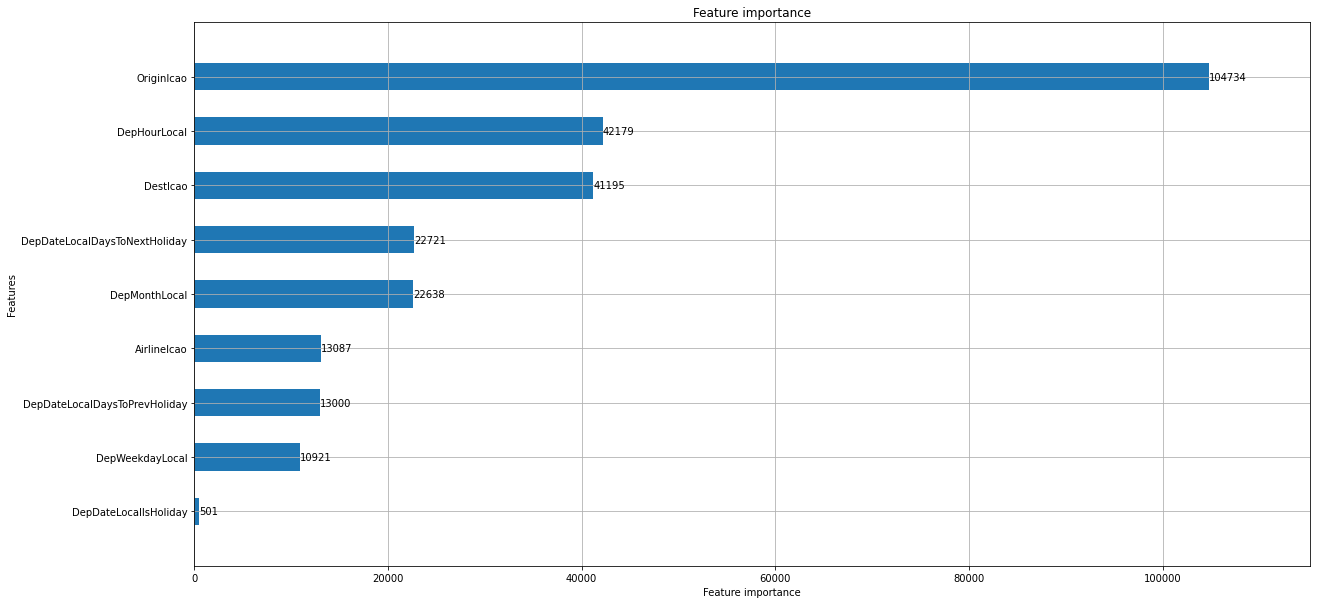

In [16]:
# Code here
lgb.plot_importance(
    model,
    figsize=(20, 10),
    height=0.5,
)

### What importance type is being shown? Check others

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

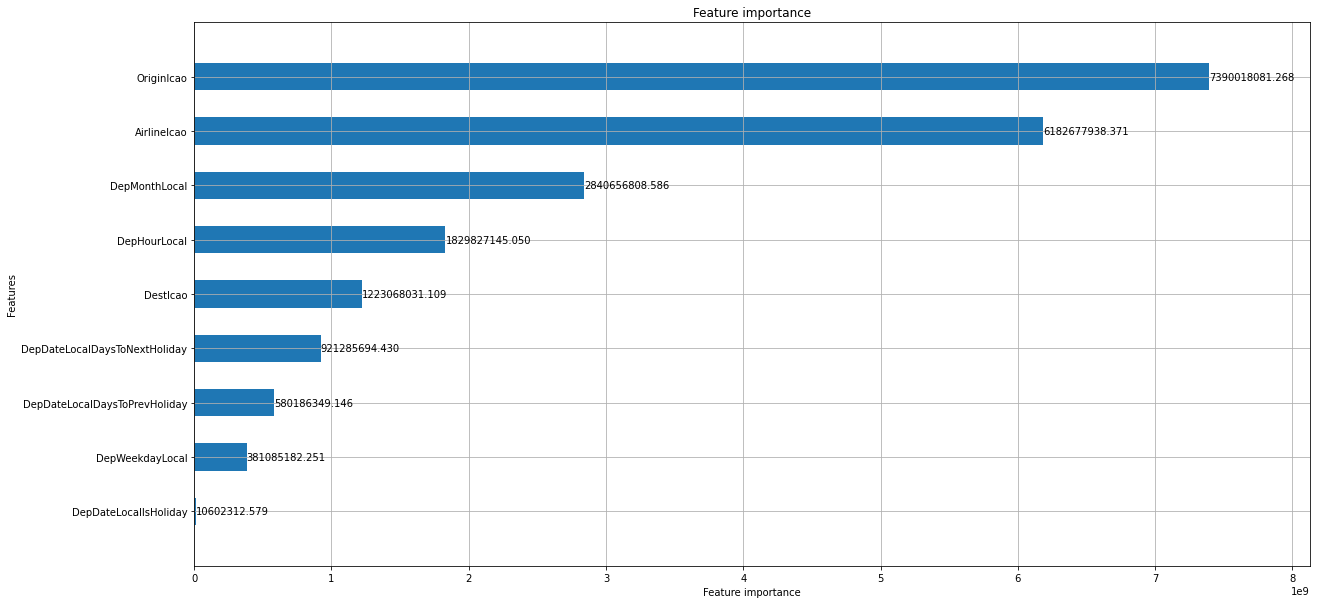

In [17]:
# Code here
lgb.plot_importance(
    model,
    figsize=(20, 10),
    height=0.5,
    importance_type="gain",
)

# Partial Dependence Plots

## Calculate partial dependence values for DepHourLocal

In [18]:
# Code here

# Choose your feature
col_to_check = "DepHourLocal"

# Make a copy of your feature
original_col = X_test[col_to_check].copy()

# Prepare structure for holding results
value_to_avg_prediction = {}

# Iterate over all possible values of column
for value in original_col.drop_duplicates().sort_values():
    print(value)

    # Assign the new value to whole column
    X_test.loc[:, col_to_check] = pd.Categorical(
        [value] * len(original_col), categories=original_col.cat.categories
    )

    # Predict
    y_pred = model.predict(X_test)

    # Calculate mean of predictions
    value_to_avg_prediction[value] = y_pred.mean()
# END LOOP

# Restore feature to original form
X_test.loc[:, col_to_check] = original_col

0
1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


## Plot partial dependence

<AxesSubplot:title={'center':'Partial dependence plot for DepHourLocal'}>

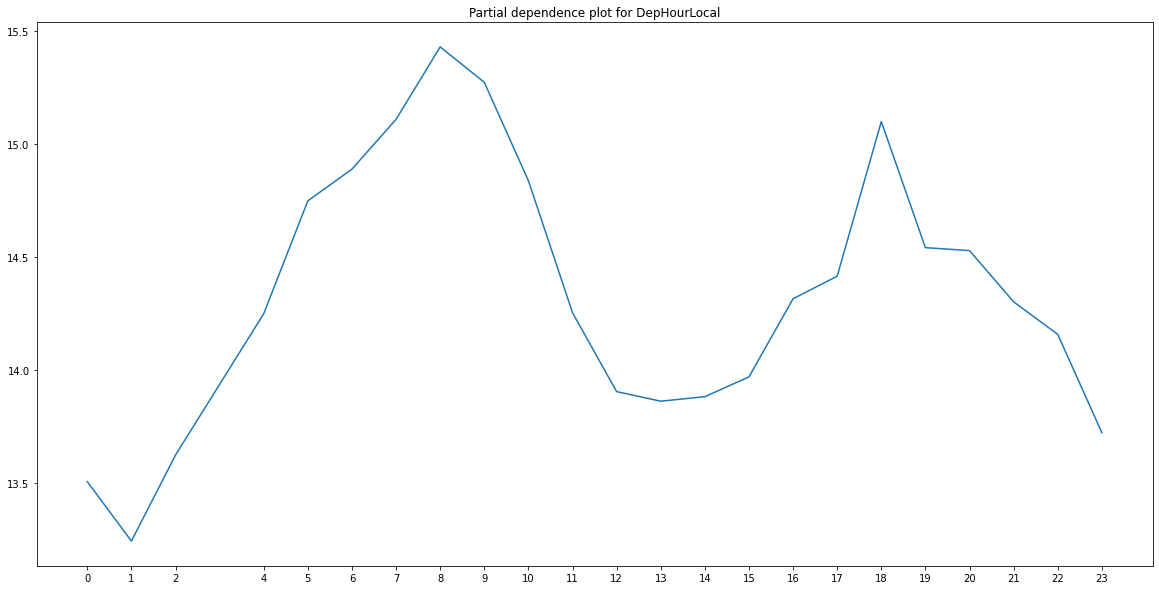

In [19]:
# Code here
pd.Series(value_to_avg_prediction).plot(
    title=f"Partial dependence plot for {col_to_check}",
    kind="line",
    figsize=(20, 10),
    xticks=list(value_to_avg_prediction),
)

# SHAP Values

[Read more about SHAP values](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d)

## Single value from Taxi dataset

### Get an example of flight from Los Angeles (KLAX) to Seattle (KSEA) that had 20min Taxi Out

In [20]:
example_to_check = X_val[
    (X_val.OriginIcao == "KLAX") & (X_val.DestIcao == "KSEA") & (y_val == 20)
][:1]
example_to_check

OriginIcao DestIcao AirlineIcao DepHourLocal DepWeekdayLocal  \
3886627       KLAX     KSEA         ASA           16               3   

        DepMonthLocal  DepDateLocalIsHoliday  DepDateLocalDaysToNextHoliday  \
3886627            11                   True                              0   

         DepDateLocalDaysToPrevHoliday  
3886627                              0

### Load model into SHAP Explainer

In [21]:
# Code here
taxi_explainer = shap.explainers.Tree(model)

### Generate & show SHAP values

In [22]:
# Code here
shap_values = taxi_explainer.shap_values(example_to_check)

pd.DataFrame(shap_values, columns=example_to_check.columns)

OriginIcao  DestIcao  AirlineIcao  DepHourLocal  DepWeekdayLocal  \
0   -0.474016 -0.194966     3.559161     -0.556954         0.189455   

   DepMonthLocal  DepDateLocalIsHoliday  DepDateLocalDaysToNextHoliday  \
0      -0.718268              -0.002077                      -0.155904   

   DepDateLocalDaysToPrevHoliday  
0                       0.154766

### Visualize SHAP values with an additive force plot

In [23]:
# Code here
shap.plots.force(taxi_explainer.expected_value, shap_values, example_to_check)

## Explaining Images with SHAP

### Helper methods for PyTorch & ImageNet

In [24]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()


# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)


def get_image_names(indexes):
    return np.vectorize(lambda x: class_names[str(x)][1])(indexes)


def adjust_shap_values(shap_values):
    return [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

### Load samples from ImageNet50 dataset

In [25]:
image_X = shap.datasets.imagenet50()[0][[49, 31, 19, 2]] / 255
normalized_X = normalize(image_X)

### Show image samples

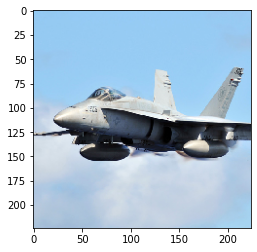

In [26]:
# Code here
plt.imshow(image_X[0])

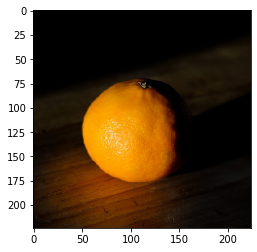

In [27]:
plt.imshow(image_X[1])

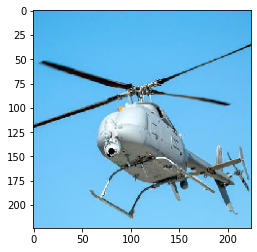

In [28]:
plt.imshow(image_X[2])

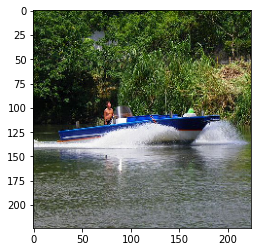

In [29]:
plt.imshow(image_X[3])

### Check model

In [30]:
# Code here
image_model

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

### Load last convolutional layer into GradientExplainer (use `normalized_X` for data parameter)

In [31]:
# Code here
image_explainer = shap.GradientExplainer(
    (image_model, image_model.features[12]), normalized_X
)

### Generate SHAP values

In [32]:
# Code here
shap_values, indexes = image_explainer.shap_values(
    normalized_X, ranked_outputs=4, nsamples=200
)

### Plot SHAP values

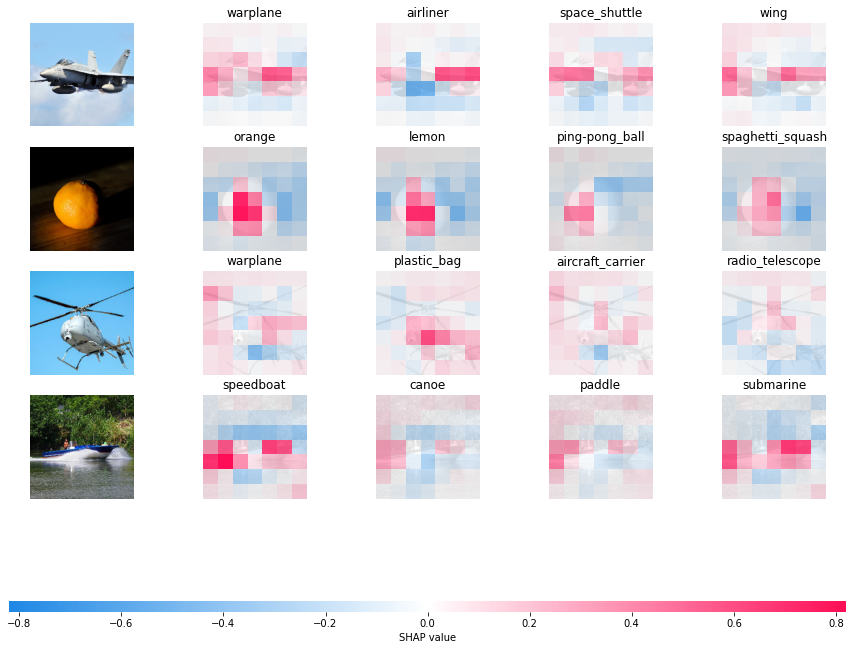

In [33]:
# Code here
shap.plots.image(
    adjust_shap_values(shap_values),
    image_X,
    get_image_names(indexes),
)

### Check what would happen if first or middle layer would be used

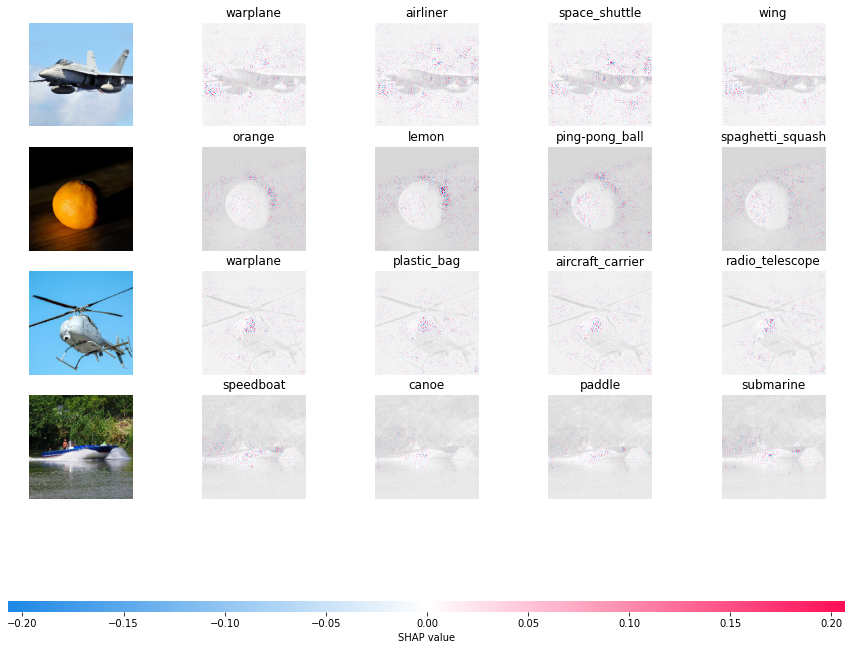

In [34]:
# Code here
image_explainer = shap.GradientExplainer(
    (image_model, image_model.features[0]), normalized_X
)
shap_values, indexes = image_explainer.shap_values(
    normalized_X, ranked_outputs=4, nsamples=200
)
shap.plots.image(
    adjust_shap_values(shap_values),
    image_X,
    get_image_names(indexes),
)

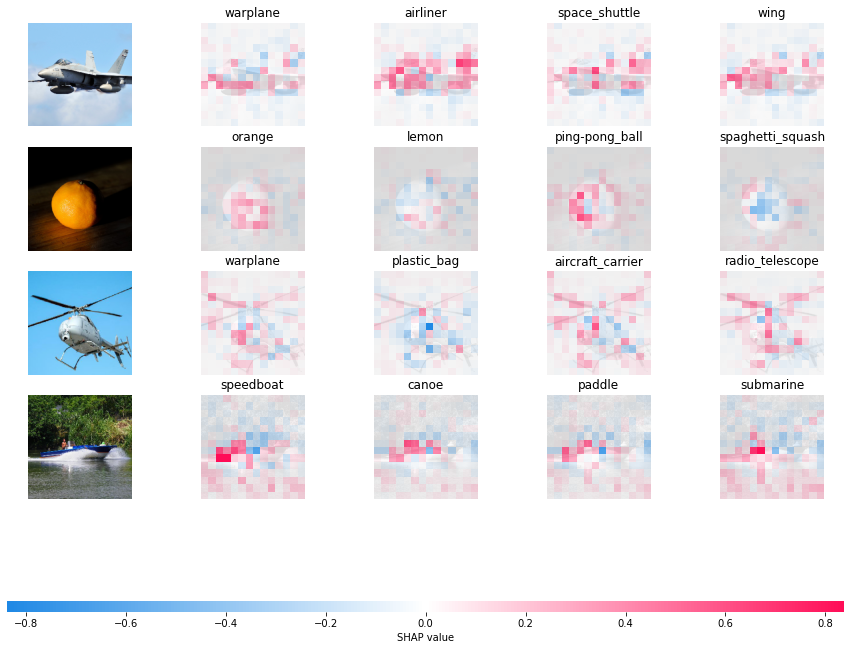

In [35]:
# Code here
image_explainer = shap.GradientExplainer(
    (image_model, image_model.features[6]), normalized_X
)
shap_values, indexes = image_explainer.shap_values(
    normalized_X, ranked_outputs=4, nsamples=200
)
shap.plots.image(
    adjust_shap_values(shap_values),
    image_X,
    get_image_names(indexes),
)

## Explaining Text with SHAP

### Load emotion dataset

In [36]:
emotion_classes = ["sadness", "joy", "love", "anger", "fear", "surprise"]
text_dataset = datasets.load_dataset("emotion", split="train")
text_data = pd.DataFrame(
    {
        "text": text_dataset["text"],
        "emotion": [emotion_classes[el] for el in text_dataset["label"]],
    }
)

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


### Show emotion dataset

In [37]:
# Code here
text_data

text  \
0                                                                                           i didnt feel humiliated   
1      i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake   
2                                                                  im grabbing a minute to post i feel greedy wrong   
3                      i am ever feeling nostalgic about the fireplace i will know that it is still on the property   
4                                                                                              i am feeling grouchy   
...                                                                                                             ...   
15995         i just had a very brief time in the beanbag and i said to anna that i feel like i have been beaten up   
15996        i am now turning and i feel pathetic that i am still waiting tables and subbing with a teaching degree   
15997                                                                                i feel strong and good overall   
15998                                                   i feel like this was such a rude comment and im glad that t   
15999                                                i know a lot but i feel so stupid because i can not portray it   

       emotion  
0      sadness  
1      sadness  
2        anger  
3         love  
4        anger  
...        ...  
15995  sadness  
15996  sadness  
15997      joy  
15998    anger  
15999  sadness  

[16000 rows x 2 columns]

### Check model

In [38]:
# Code here
text_model.model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Load model into Explainer

In [39]:
# Code here
text_explainer = shap.Explainer(text_model)

### Generate SHAP values for examples from each emotion

In [40]:
# Code here
shap_values = text_explainer(text_data.drop_duplicates("emotion")["text"])

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 3/6 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 5/6 [00:35<00:07,  7.75s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 6/6 [00:48<00:00,  9.90s/it]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 7it [01:02, 15.72s/it]                       


### Plot SHAP values

In [41]:
# Code here
shap.plots.text(shap_values)